In [1]:
import numpy as np
import matplotlib.pylab as plt
import sgd
from model import EmbeddingModel


In [2]:
vocabulary, titles, texts = sgd.scan_text('test-2.csv', 30)

In [3]:
len(titles)

7405

In [3]:
#stratify sample on validation and train set
ratio = 0.8
middle = int(len(titles) * ratio)
train_titles, val_titles = titles[:middle], titles[middle:]
train_texts, val_texts = texts[:middle], texts[middle:]

In [4]:
middle

5924

In [6]:
list(vocabulary.keys())[list(vocabulary.values())[1456]]

'size2'

In [5]:
model = EmbeddingModel(vocabulary)
#scalene_profiler.start()
model.train(train_titles, train_texts, val_titles, val_texts, number_of_epoch = 50)
#scalene_profiler.stop()



In [6]:
model.mtx_embed

array([[ 0.0008547 , -0.01009121,  0.00598026, ...,  0.04692796,
        -0.00588323,  0.00079107],
       [ 0.0401038 ,  0.00889102,  0.04737478, ...,  0.15763605,
         0.02353681,  0.04076089],
       [-0.6675631 , -0.6205442 , -0.667035  , ..., -0.7386246 ,
        -0.64965975, -0.6771847 ],
       ...,
       [ 0.27501458,  0.275502  ,  0.26648185, ...,  0.17782724,
         0.28297928,  0.28137252],
       [-0.38153788, -0.37834015, -0.38256374, ..., -0.34253085,
        -0.38038394, -0.38413045],
       [-0.11580884, -0.11659723, -0.11811967, ..., -0.05859023,
        -0.11703522, -0.12035593]], dtype=float32)

In [8]:
model.calculate_metric(val_titles, val_texts)

In [10]:
val_titles[690]

[555, 63, 1254, 3, 9, 437, 752]

In [15]:
mtx = model.mtx_embed[:10]

In [16]:
mtx

array([[ 0.02255207,  1.0721966 ,  0.19126661, ...,  0.14428064,
        -0.82008135, -0.2927166 ],
       [ 0.0034248 , -1.7041072 , -0.51010907, ..., -0.41126084,
         1.3438236 ,  0.74833596],
       [ 0.49981508,  2.3993628 ,  0.8288301 , ...,  0.74396247,
        -1.8432444 , -1.030569  ],
       ...,
       [-0.9568535 , -1.5528826 , -0.69636744, ..., -0.72829217,
         0.9802898 ,  0.54686046],
       [ 0.4862126 , -0.17232405,  0.58885276, ...,  0.586254  ,
        -0.09194825, -0.58084846],
       [ 0.65336734,  0.70336825,  0.7885391 , ...,  0.74768907,
        -0.77506846, -0.8528041 ]], dtype=float32)

In [17]:
result = np.dot(mtx, mtx.T)

In [18]:
vocabulary

{'UNKNOWN': 0,
 'fears': 1,
 'for': 2,
 't': 3,
 'n': 4,
 'pension': 5,
 'after': 6,
 'talks': 7,
 'unions': 8,
 'representing': 9,
 'workers': 10,
 'at': 11,
 'turner': 12,
 'newall': 13,
 'say': 14,
 'they': 15,
 'are': 16,
 'disappointed': 17,
 'with': 18,
 'parent': 19,
 'firm': 20,
 'federal': 21,
 'mogul': 22,
 'the': 23,
 'race': 24,
 'is': 25,
 'on': 26,
 'second': 27,
 'private': 28,
 'team': 29,
 'sets': 30,
 'launch': 31,
 'date': 32,
 'human': 33,
 'spaceflight': 34,
 'spacecom': 35,
 'toronto': 36,
 'canada': 37,
 'a': 38,
 'of': 39,
 'competing': 40,
 'million': 41,
 'ansari': 42,
 'x': 43,
 'prize': 44,
 'contest': 45,
 'suborbital': 46,
 'space': 47,
 'flight': 48,
 'has': 49,
 'officially': 50,
 'announced': 51,
 'its': 52,
 'manned': 53,
 'rocket': 54,
 'ky': 55,
 'company': 56,
 'wins': 57,
 'grant': 58,
 'to': 59,
 'study': 60,
 'peptides': 61,
 'ap': 62,
 'founded': 63,
 'by': 64,
 'chemistry': 65,
 'researcher': 66,
 'university': 67,
 'louisville': 68,
 'won': 69

In [19]:
np.argsort(result, axis=1)

array([[6, 1, 7, 4, 8, 0, 9, 3, 2, 5],
       [5, 3, 2, 9, 0, 8, 7, 4, 1, 6],
       [6, 4, 1, 7, 8, 0, 9, 2, 3, 5],
       [6, 4, 7, 1, 0, 8, 9, 2, 3, 5],
       [5, 3, 2, 9, 8, 0, 1, 7, 4, 6],
       [6, 4, 7, 1, 0, 8, 9, 2, 3, 5],
       [5, 3, 2, 9, 8, 0, 1, 7, 4, 6],
       [5, 3, 2, 9, 0, 8, 1, 7, 4, 6],
       [6, 4, 7, 1, 0, 8, 9, 2, 3, 5],
       [6, 4, 7, 1, 0, 8, 9, 2, 3, 5]])

In [6]:
mtx_embed = model.mtx_embed
#norms = mtx_embed.sum(axis=1, keepdims=True)
#mtx_embed = mtx_embed/norms
#mtx_embed = mtx_embed[1:]

In [8]:
res = np.dot(mtx_embed, mtx_embed.T)

In [9]:
np.argsort(res, axis=1)

array([[ 523, 1172,  520, ...,   46,    0,   49],
       [ 523, 1172,  520, ...,   46,    0,   49],
       [ 523, 1172,  520, ...,   46,    0,   49],
       ...,
       [ 523, 1172,  520, ...,   46,    0,   49],
       [ 523, 1172,  520, ...,   46,    0,   49],
       [ 523, 1172,  520, ...,   46,    0,   49]])

In [86]:
np.argsort(np.dot(mtx_embed, mtx_embed.T))

array([[  77,  542,  696, ..., 3063, 3362, 3031],
       [  77,  542,  696, ..., 3063, 3362, 3031],
       [  77,  542,  696, ..., 3063, 3362, 3031],
       ...,
       [  77,  542,  696, ..., 3063, 3362, 3031],
       [  77,  542,  696, ..., 3063, 3362, 3031],
       [  77,  542,  696, ..., 3063, 3362, 3031]])

In [84]:
a = np.array([[1,2], [3,4], [7,1]])
b = a.T

In [85]:
np.argsort(np.dot(a, b), axis=1)

array([[0, 2, 1],
       [0, 1, 2],
       [0, 1, 2]])

In [75]:
res = np.multiply(mtx_embed, mtx_embed.T)

ValueError: operands could not be broadcast together with shapes (3635,300) (300,3635) 

In [59]:
for id, item in enumerate(res[2]):
    if (item >= 122229).any():
        print(id)

3032


In [60]:
len(res[2])

3636

In [66]:
np.max(res[2])

44671.34

In [70]:
ress 

array([[  77,  542,  696, ..., 3063, 3362, 3031],
       [  77,  542,  696, ..., 3063, 3362, 3031],
       [  77,  542,  696, ..., 3063, 3362, 3031],
       ...,
       [  77,  542,  696, ..., 3063, 3362, 3031],
       [  77,  542,  696, ..., 3063, 3362, 3031],
       [  77,  542,  696, ..., 3063, 3362, 3031]])

In [67]:
ress =np.argpartition(res[0], -4)[-4:]

In [12]:
list(vocabulary.keys())[list(vocabulary.values())[4]]

'pension'

In [19]:
model.vocabulary

{'UNKNOWN': 0,
 'for': 1,
 'T': 2,
 'N': 3,
 'pension': 4,
 'after': 5,
 'talks': 6,
 'Unions': 7,
 'workers': 8,
 'at': 9,
 'say': 10,
 'they': 11,
 'are': 12,
 'with': 13,
 'parent': 14,
 'firm': 15,
 'Federal': 16,
 'The': 17,
 'Race': 18,
 'is': 19,
 'On': 20,
 'Second': 21,
 'Team': 22,
 'Sets': 23,
 'Launch': 24,
 'Human': 25,
 'SPACEcom': 26,
 'TORONTO': 27,
 'Canada': 28,
 'A': 29,
 'of': 30,
 'the': 31,
 'million': 32,
 'X': 33,
 'Prize': 34,
 'a': 35,
 'contest': 36,
 'space': 37,
 'flight': 38,
 'has': 39,
 'officially': 40,
 'announced': 41,
 'date': 42,
 'its': 43,
 'rocket': 44,
 'Company': 45,
 'Wins': 46,
 'to': 47,
 'Study': 48,
 'AP': 49,
 'company': 50,
 'by': 51,
 'University': 52,
 'Louisville': 53,
 'won': 54,
 'develop': 55,
 'better': 56,
 'which': 57,
 'short': 58,
 'building': 59,
 'Unit': 60,
 'Helps': 61,
 'Forecast': 62,
 'It': 63,
 'barely': 64,
 'when': 65,
 'Mike': 66,
 'starts': 67,
 'his': 68,
 'shift': 69,
 'figures': 70,
 'and': 71,
 'but': 72,
 'alr

In [18]:
list(vocabulary.keys())[list(vocabulary.values())[6]]

'talks'

In [38]:
vocabulary

{'UNKNOWN': 0,
 'Title': 1,
 'Description': 2,
 'Wall': 3,
 'St': 4,
 'Bears': 5,
 'Back': 6,
 'Into': 7,
 'the': 8,
 'Black': 9,
 'Reuters': 10,
 'Streets': 11,
 'of': 12,
 'are': 13,
 'seeing': 14,
 'green': 15,
 'again': 16,
 'Carlyle': 17,
 'Looks': 18,
 'Toward': 19,
 'Commercial': 20,
 'Aerospace': 21,
 'Private': 22,
 'investment': 23,
 'firm': 24,
 'has': 25,
 'a': 26,
 'reputation': 27,
 'for': 28,
 'making': 29,
 'and': 30,
 'plays': 31,
 'in': 32,
 'defense': 33,
 'industry': 34,
 'quietly': 35,
 'bets': 36,
 'on': 37,
 'another': 38,
 'part': 39,
 'market': 40,
 'Oil': 41,
 'Economy': 42,
 'Cloud': 43,
 'Stocks': 44,
 'Outlook': 45,
 'Soaring': 46,
 'crude': 47,
 'prices': 48,
 'plus': 49,
 'economy': 50,
 'outlook': 51,
 'earnings': 52,
 'expected': 53,
 'over': 54,
 'stock': 55,
 'next': 56,
 'week': 57,
 'during': 58,
 'depth': 59,
 'doldrums': 60,
 'Iraq': 61,
 'Halts': 62,
 'Exports': 63,
 'from': 64,
 'Main': 65,
 'Southern': 66,
 'Pipeline': 67,
 'Authorities': 68,
 

In [21]:
ress

array([[  78,  543,  697, ..., 3064, 3363, 3032],
       [  78,  543,  697, ..., 3064, 3363, 3032],
       [  78,  543,  697, ..., 3064, 3363, 3032],
       ...,
       [  78,  543,  697, ..., 3064, 3363, 3032],
       [  78,  543,  697, ..., 3064, 3363, 3032],
       [  78,  543,  697, ..., 3064, 3363, 3032]])

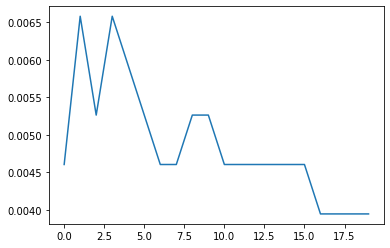

In [ ]:
x, y = zip(*metric_res.items()) # unpack a list of pairs into two tuples
plt.plot(x, y)
plt.show()

In [ ]:
mtx_title

matrix([[  5.4421955 ,  -1.7373425 ,   1.43631831, ...,   4.8000366 ,
           0.47950566,   2.89896708],
        [ -1.97534146,   4.19479803,  -3.8395173 , ...,   0.82559434,
          -5.46617508,   3.03338888],
        [  2.24744181, -11.38456049,  11.5548968 , ...,  -0.55829894,
          14.33150294,  -7.30689764],
        ...,
        [-10.85796181,  -6.85457865,   5.99761995, ..., -11.15495483,
           3.47317998,  -8.80698268],
        [  5.65702614,   5.73578446,  -4.79274439, ...,   6.81075638,
          -5.81879889,   5.04540909],
        [ -2.96617123,  -1.73913302,   0.79456488, ...,  -2.65210379,
           1.63446846,  -3.4652425 ]])

In [ ]:
a = mtx_embed.dot(mtx_embed.T)
result = np.argmax(a, axis=1)

In [ ]:
result

array([1013, 2034,   61, ...,   71,   71,   71])

In [ ]:
list(token_number.keys())[list(token_number.values())[409]] 

'Reuters'

In [ ]:
counter

6

In [ ]:
counter = 0
for idx in range(number_of_docs):
    if idx == np.argmax(res, axis=1)[0]:
        counter += 1
